<a href="https://colab.research.google.com/github/divyalaldinani/Deep-Learning-in-PyTorch/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [340]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [341]:
def f(x):
    return 3*x**2 - 4*x + 5

In [342]:
f(3.0)

20.0

In [343]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

In [344]:
xs, ys

(array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
        -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
        -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
         1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
         4.  ,  4.25,  4.5 ,  4.75]),
 array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
         55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
         25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
          7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
          4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
         13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
         37.    ,  42.1875,  47.75  ,  53.6875]))

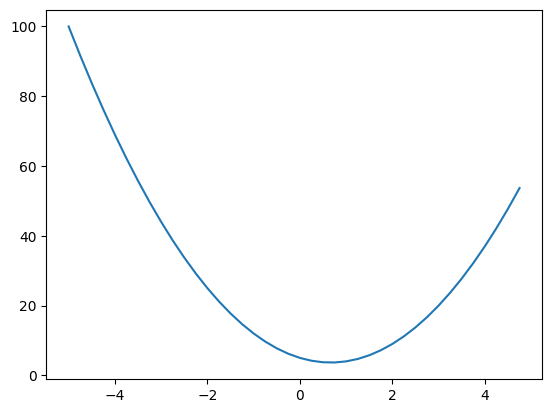

In [345]:
plt.plot(xs, ys)

In [346]:
h = 0.000000001
x = -3.0

In [347]:
f(x+h)

43.999999978

In [348]:
(f(x+h)-f(x))/h # derivative of f(x) at x = 3.0

-22.000001820288162

In [349]:
h = 0.0000001
x = 2/3
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [350]:
## a little complex function
a = 2.
b = -3.
c = 10.
d = a*b + c
d

4.0

In [351]:
h = 0.0001

# derivative at a point
a = 2.0
b = -3.0
c = 10.0

d_actual = a*b + c
d1 = (a+h)*b + c
print(f"slope wrt a is {(d1-d_actual)/h}")

slope wrt a is -3.000000000010772


In [352]:
d1

3.999699999999999

In [353]:
d2 = a*(b+h) + c
print(f"slope wrt b is {(d2-d_actual)/h}")

slope wrt b is 2.0000000000042206


In [354]:
d3 = a*b + (c+h)
print(f"slope wrt is {(d3-d_actual)/h}")

slope wrt is 0.9999999999976694


### started working on NN

In [355]:
class Value:

    def __init__(self, data, _children=(), _op = '', label = '' ): # children is the set of nodes that are involved in the making of a particular node, like d = a*b has children = {a, b}, label = var_name, op = '*'
        self.data = data
        self.grad = 0.0 # d(output)/d(node)
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): # defines the way to print an object
        return f"Value(data={self.data}), label='{self.label}'"

    def __add__(self, other): # addition(+) operation on values objects
        other = other if isinstance(other, Value) else Value(other) # in case other is constant
        out = Value(self.data + other.data, (self, other), '+')

        def _backward() :
            self.grad += out.grad # accumulating grads if a var is used more than once, initially when the var is created, grad is 0
            other.grad += out.grad
            # in addition, gradient flows through inputs

        out._backward = _backward
        return out

    def __radd__(self, other):
      return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # in case other is constant
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # y = x1*w1, dx1/dy = w1 * dy/dy, dw1/dy = x1 * dy/dy
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self, in case self is constant and other is Value object
        return self * other

    def __truediv__(self, other):
        return self*other**(-1)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh' )

        def _backward():
            self.grad += (1 - t ** 2)*out.grad # y = tanh(x), dy/dx = 1-tanh(x)**2*dx/dx = 1-y**2 * dx/dx

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad = other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'tanh' )

        def _backward():
            self.grad += out.data * out.grad # y = tanh(x), dy/dx = 1-tanh(x)**2*dx/dx = 1-y**2 * dx/dx

        out._backward = _backward
        return out

    def __neg__(self):
        return self*(-1)

    def __sub__(self, other):
        return self + (-other)

    def backward(self):
      # topo logical sort to call backward function from rightmost node towards left node and call backward fn such that all nodes on the right of a node are processed before calling backward for a particular node

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self) # only calld for output variable/loss fn
      self.grad = 1.0
      for node in reversed(topo):
          node._backward()


a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L

Value(data=-8.0), label='L'

In [356]:
(a.__mul__(b)).__add__(c)

Value(data=4.0), label=''

In [357]:
d._op

'+'

In [358]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op: # op nodes
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [359]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data

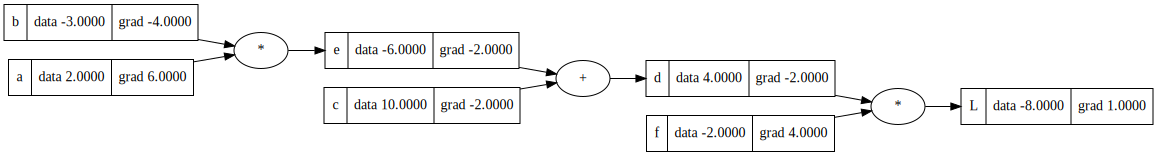

In [360]:
draw_dot(L)

In [361]:
def lol():
  h = 0.00001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label = 'L'
  L1 = L.data


  a = Value(2.0, label = 'a')
  # a.data += h
  b = Value(-3.0, label = 'b')
  b.data += h
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h) # dL/dd


In [362]:
lol()

-4.000000000026205


dL / dc = dL/dd * dd/dc = dL/dd * 1.0 = dL/dd<br>
dd / dc = 1.0<br>
d = c+e


dL/de = -2

dL/da = ?

dL/da = dL/de * de/da = dL/de * b =
e = a*b


In [363]:
## changing leaf nodes in the direction of their respective gradient to increase the value of L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = c + e
L = d * f
L # l increases

Value(data=-7.286496), label=''

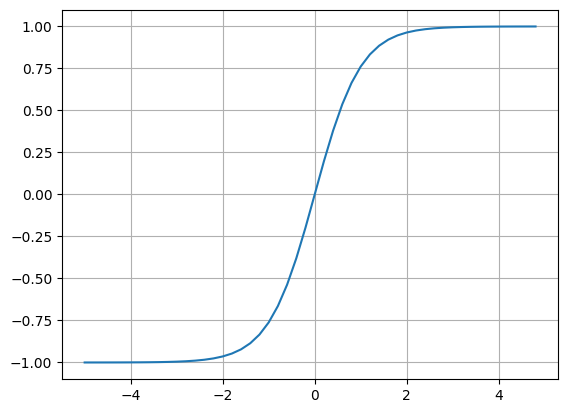

In [364]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));
plt.grid()

### Simple NN

In [365]:
#inputs: x1, x2, weights: w1, w2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [366]:
# o.grad = 1.0

# # o = tanh(n), do/dn = 1-tanh(n)**2
# # do/dn = 1-o**2
# n.grad = 1-o.data**2
# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# # do/dx2 = do/dx2w2 * dx2w2/dx2 = do/dx2w2 * w2
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data

In [367]:
# o.grad = 1.0
# o._backward()


# n._backward()

# b._backward()

# x1w1x2w2._backward()

# x1w1._backward()
# x2w2._backward()

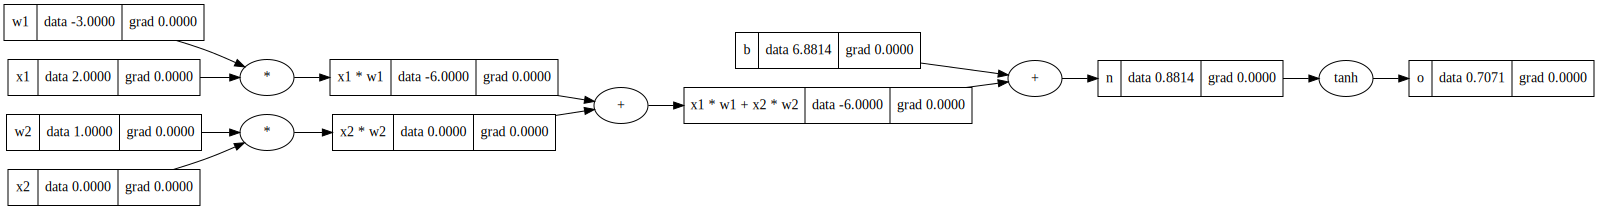

In [368]:
draw_dot(o)

In [369]:
h=0.001
o_dash = (x2.data + x2.grad*h)*(w2.data + w2.grad*h) + (x1.data + x1.grad*h)*(w1.data + w1.grad*h) + b.data
o_dash

0.8813735870195432

In [370]:
o.backward()

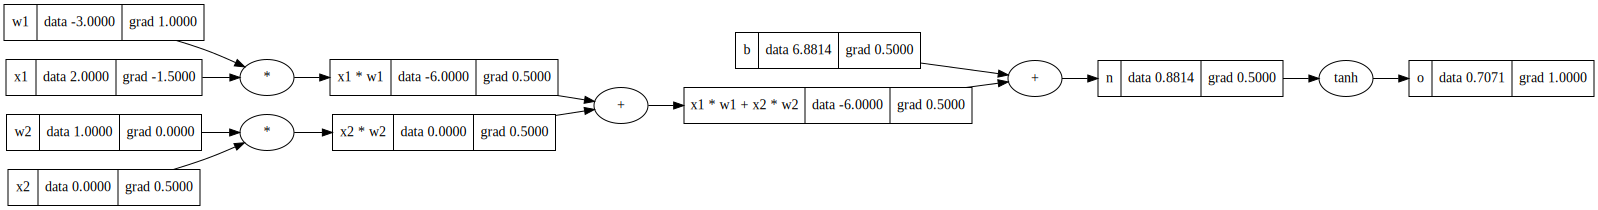

In [371]:
draw_dot(o)

In [372]:
a = Value(1.0, label ='a')
b = a+a; b.label = 'b'
b.backward()

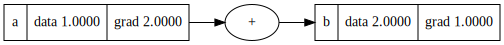

In [373]:
draw_dot(b)

ðŸ”‘Without accumulating grads, a.grad would have been 1.0 which is incorrect.<br>
reason:<br>
b = a+a<br>
when gradient flows through b, it initializes<br>
a.grad = 1.0<br>
a.grad = 1.0


In [374]:
a = Value(1.0)
2*a

Value(data=2.0), label=''

In [375]:
a.exp()

Value(data=2.718281828459045), label=''

In [376]:
a = Value(2.0)
b = Value(4.0)
a/b

Value(data=0.5), label=''

In [377]:
#inputs: x1, x2, weights: w1, w2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp();
o = (e-1)/(e+1); e.label = 'e'

o.label = 'o'
o.backward()

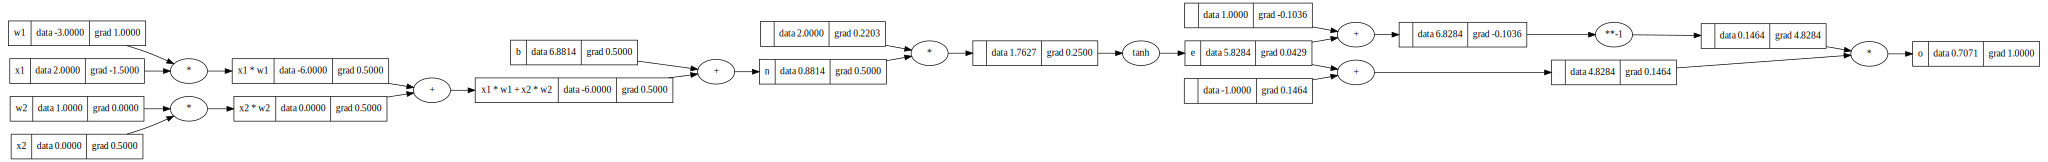

In [378]:
draw_dot(o)

## Doing this using PyTorch

In [379]:
import torch

In [380]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True # torch assumes that scalars dont require backward prop
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True # torch assumes that scalars dont require backward prop
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True # torch assumes that scalars dont require backward prop
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True # torch assumes that scalars dont require backward prop
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True # torch assumes that scalars dont require backward prop


n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print('o: ', o.data.item())
o.backward()


o:  0.7071066904050358


In [381]:
# x1.grad returns grad tensor, .item() returns the data item of tensor
print('x2', x2.grad)
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

x2 tensor([0.5000], dtype=torch.float64)
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [382]:
o.item()

0.7071066904050358

In [383]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # each output neurons is connected to each input neuron

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron .parameters()]

class MLP: # multi layer perceptron
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [384]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.06142639579449249), label=''

In [385]:
n.parameters()

[Value(data=-0.6965076980089497), label='',
 Value(data=-0.6420335145292682), label='',
 Value(data=-0.37748621454844566), label='',
 Value(data=0.7879810890499532), label='',
 Value(data=-0.8646983945712869), label='',
 Value(data=-0.20355957704410366), label='',
 Value(data=-0.17852734750379717), label='',
 Value(data=0.907093168915611), label='',
 Value(data=-0.4336732365605023), label='',
 Value(data=-0.7778128754135614), label='',
 Value(data=0.2617382559693233), label='',
 Value(data=0.002058304933672428), label='',
 Value(data=0.015556174978194726), label='',
 Value(data=0.6503207026632434), label='',
 Value(data=0.3836773799571809), label='',
 Value(data=0.8529230378666164), label='',
 Value(data=-0.13604629358312015), label='',
 Value(data=-0.3026514939520484), label='',
 Value(data=-0.11462897948024642), label='',
 Value(data=-0.8879510570400917), label='',
 Value(data=0.06885794939538536), label='',
 Value(data=-0.7602483487953033), label='',
 Value(data=0.21999885360848648)

In [386]:
n(x).backward()
# draw_dot(n(x))

In [387]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# ys = [Value(y) for y in ys]
ys

[1.0, -1.0, -1.0, 1.0]

In [388]:
y_preds = [n(x) for x in xs] # getting all preds
y_preds

[Value(data=0.06142639579449249), label='',
 Value(data=0.11060236025444446), label='',
 Value(data=0.25118073936360225), label='',
 Value(data=0.2831474572544147), label='']

In [389]:
zip(ys, y_preds)

In [390]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, y_preds))

In [391]:
# draw_dot(loss)

In [392]:
loss

Value(data=4.193688823709321), label=''

In [393]:
loss.backward()

In [394]:
n.layers[0].neurons[0].w[0].grad

-0.19434865875175703

In [395]:
# draw_dot(loss)

In [396]:
n.layers[0].neurons[0].w[0].data

-0.6965076980089497

In [397]:
lr = 0.01
for p in n.parameters():
  p.data += -p.grad*lr

In [398]:
n.layers[0].neurons[0].w[0].grad

-0.19434865875175703

In [399]:
n.layers[0].neurons[0].w[0].data

-0.6945642114214322

In [400]:
y_preds = [n(x) for x in xs]
loss = sum((y_pred- y_true)**2 for y_pred, y_true in zip(y_preds, ys))
loss

Value(data=4.091446306046115), label=''

In [403]:
print(f"y_true is {ys}")
lr = 0.05

for iter in range(20):

    loss.backward()

    for p in n.parameters():
      p.data += -p.grad*lr
      # remember that we do grad += ... as we have to accumulate them in backward pass
      # thus we need to 0 them after backward pass

    # 0 grad
    for p in n.parameters():
      p.grad = 0

    y_preds = [n(x) for x in xs]

    loss = sum((y_pred- y_true)**2 for y_pred, y_true in zip(y_preds, ys))
    print(f"iter is {iter} | loss is {loss.data}")

y_true is [1.0, -1.0, -1.0, 1.0]
iter is 0 | loss is 0.0788939243927507
iter is 1 | loss is 0.07159304325687811
iter is 2 | loss is 0.06538647085212952
iter is 3 | loss is 0.060064465677213325
iter is 4 | loss is 0.055464638049595436
iter is 5 | loss is 0.05145980761926149
iter is 6 | loss is 0.04794934001707086
iter is 7 | loss is 0.04485285700288394
iter is 8 | loss is 0.04210560198931899
iter is 9 | loss is 0.03965498184830601
iter is 10 | loss is 0.03745795781776022
iter is 11 | loss is 0.03547905757616695
iter is 12 | loss is 0.033688847009414026
iter is 13 | loss is 0.03206274564184629
iter is 14 | loss is 0.030580101343707134
iter is 15 | loss is 0.029223462288610405
iter is 16 | loss is 0.027978000141648165
iter is 17 | loss is 0.026831050043800868
iter is 18 | loss is 0.025771741424516673
iter is 19 | loss is 0.02479069991522069


In [404]:
 y_preds

[Value(data=0.9168493712090835), label='',
 Value(data=-0.9340527241088196), label='',
 Value(data=-0.8907633730214557), label='',
 Value(data=0.9600626869233946), label='']

reference: https://youtu.be/VMj-3S1tku0?si=kmrSpIkajZCI12sy